# Maxence Lasbordes | MASH

In [432]:
%%capture
!pip install transformers datasets

In [433]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tabulate import tabulate
from datasets import load_dataset
from tqdm import tqdm
from transformers import BertTokenizer

This is a template of the notebook that you should complete and enrich with your own code.

First cells will be the same than the ones of the lab on text convolution.

# Data loading


In [434]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [435]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [436]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

Same celel than in the lab session.

🚧 **TODO** 🚧

Read the documentation about HuggingFace dataset and complete the code below.
You should:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [437]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle(seed=42)

# Select 5000 samples
dataset = dataset.select(range(n_samples))

# Tokenize the dataset
dataset = dataset.map(lambda x: preprocessing_fn(x, tokenizer))

# Remove useless columns
dataset = dataset.remove_columns(["review", "sentiment"])

# Split the train and validation
split = dataset.train_test_split(test_size=0.2, seed=42)

document_train_set = split["train"]
document_valid_set = split["test"]

print(document_train_set[0])

{'review_ids': [1996, 24385, 2003, 1037, 2428, 2204, 10874, 1012, 1998, 3492, 14888, 1012, 1045, 2228, 2057, 2064, 2035, 5993, 2008, 1996, 9592, 1997, 2770, 2046, 1037, 18224, 24385, 2024, 2172, 7046, 2084, 2770, 2046, 9219, 1010, 6144, 2030, 14106, 1012, 2008, 1005, 1055, 3599, 2339, 2023, 3185, 2003, 2061, 12459, 1012, 2076, 2023, 2143, 1010, 2017, 1005, 2222, 2763, 2228, 2055, 2115, 2219, 24385, 1037, 2261, 2335, 1012, 3251, 2002, 1005, 1055, 5214, 1997, 2725, 2107, 2477, 1012, 1012, 1012, 2017, 2488, 11839, 2010, 2564, 2987, 1005, 1056, 21910, 2006, 2032, 1012, 2008, 1005, 1055, 2054, 1996, 2466, 2003, 2035, 2055, 1012, 1037, 9768, 24385, 1999, 2474, 20057, 2043, 2002, 4858, 2041, 2010, 2564, 2003, 16789, 2006, 2032, 2007, 1996, 4770, 1011, 2879, 1012, 1006, 2008, 2442, 2022, 1996, 4602, 9518, 1999, 1996, 2088, 1010, 2011, 1996, 2126, 1012, 4770, 24916, 2467, 2202, 5056, 1997, 1996, 2160, 23744, 2043, 1996, 3129, 2003, 2012, 2010, 2147, 1007, 2013, 2059, 2006, 2256, 24385, 1010, 28

In [438]:
print(len(document_train_set))

4000


In [439]:
class ConvolutionModel(nn.Module):
    def __init__(self, embedding_dim, conv_dim, vocab_size, num_classes):
        super(ConvolutionModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, conv_dim, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc = nn.Linear(conv_dim, num_classes)

    def forward(self, x):
        x = self.embed(x)
        x = x.permute(0, 2, 1)  # (batch_size, embed_size, sequence_length)
        x = self.conv(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        x = self.fc(x)
        return x

In [440]:
def load_model(model_path, model):
    # Load the saved Word2Vec embeddings
    checkpoint = torch.load(model_path)
    embeddings = checkpoint["context_embed"]

    # Load the embeddings from the word2vec pre-trained model
    model.embed.weight.data.copy_(embeddings)

    return model

In [441]:
class ClassificationDataset(Dataset):
    def __init__(self, dataset, max_length):
        self.dataset = dataset
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        if len(sample["review_ids"]) < self.max_length:
            pad = self.max_length - len(sample["review_ids"])
            sample["review_ids"].extend([0] * pad)

        return (torch.tensor(sample["review_ids"]), torch.tensor(sample["label"]))

In [442]:
def train(model, train_loader, val_loader, num_epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):

        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader, desc="Training"):
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for x, y in val_loader:
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
                val_acc += (y_pred.argmax(1) == y).sum().item()

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_acc / len(val_loader.dataset)

        print(
            f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

In [443]:
# Loading the dataset
train_set = ClassificationDataset(document_train_set, max_length=256)
val_set = ClassificationDataset(document_valid_set, max_length=256)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)

In [444]:
# Training the model with loaded embeddings
model_1 = ConvolutionModel(
    embedding_dim=100, conv_dim=100, vocab_size=tokenizer.vocab_size, num_classes=2
)
model_1 = load_model("model_dim-100_radius-10_ratio-2-batch-256-epoch-5.ckpt", model_1)
train(model_1, train_loader, val_loader, num_epochs=5, lr=0.001)

C:\Users\mlasb\AppData\Local\Temp\ipykernel_12908\1943147724.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
Training:   0%|         

Training: 100%|██████████| 250/250 [00:06<00:00, 39.54it/s]


Epoch 1/5 | Train Loss: 0.0429, Val Loss: 0.0405, Val Acc: 0.6590


Training: 100%|██████████| 250/250 [00:06<00:00, 41.18it/s]


Epoch 2/5 | Train Loss: 0.0315, Val Loss: 0.0349, Val Acc: 0.7150


Training: 100%|██████████| 250/250 [00:05<00:00, 43.75it/s]


Epoch 3/5 | Train Loss: 0.0163, Val Loss: 0.0317, Val Acc: 0.7530


Training: 100%|██████████| 250/250 [00:05<00:00, 43.65it/s]


Epoch 4/5 | Train Loss: 0.0055, Val Loss: 0.0317, Val Acc: 0.7540


Training: 100%|██████████| 250/250 [00:05<00:00, 43.18it/s]


Epoch 5/5 | Train Loss: 0.0017, Val Loss: 0.0325, Val Acc: 0.7470


In [445]:
# Training the model with random embeddings
model_2 = ConvolutionModel(
    embedding_dim=100, conv_dim=100, vocab_size=tokenizer.vocab_size, num_classes=2
)
train(model_2, train_loader, val_loader, num_epochs=5, lr=0.001)

Training: 100%|██████████| 250/250 [00:06<00:00, 41.44it/s]


Epoch 1/5 | Train Loss: 0.0402, Val Loss: 0.0386, Val Acc: 0.6260


Training: 100%|██████████| 250/250 [00:06<00:00, 41.17it/s]


Epoch 2/5 | Train Loss: 0.0259, Val Loss: 0.0302, Val Acc: 0.7600


Training: 100%|██████████| 250/250 [00:06<00:00, 40.81it/s]


Epoch 3/5 | Train Loss: 0.0155, Val Loss: 0.0287, Val Acc: 0.7840


Training: 100%|██████████| 250/250 [00:06<00:00, 40.31it/s]


Epoch 4/5 | Train Loss: 0.0083, Val Loss: 0.0287, Val Acc: 0.7840


Training: 100%|██████████| 250/250 [00:06<00:00, 40.83it/s]


Epoch 5/5 | Train Loss: 0.0034, Val Loss: 0.0302, Val Acc: 0.7770


###########################################################################

In [446]:
import matplotlib.pyplot as plt


def plot_accuracy_embed(embedding_dims, epoch_accuracy_scores_dict):
    plt.figure(figsize=(10, 6))

    for embedding_dim in embedding_dims:
        epoch_accuracy_scores = epoch_accuracy_scores_dict[embedding_dim]
        epochs = list(
            range(1, len(epoch_accuracy_scores) + 1)
        )  # Generate epoch numbers

        plt.plot(
            epochs,
            epoch_accuracy_scores,
            marker="o",
            linestyle="-",
            label=f"Embedding Dim: {embedding_dim}",
        )

    # Adding titles and labels
    plt.title("Validation Accuracy over Epochs for Different Embedding Dimensions")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.ylim(0, 1)
    plt.xticks(
        list(range(1, max(len(v) for v in epoch_accuracy_scores_dict.values()) + 1))
    )  # Set x-ticks to be the epoch numbers
    plt.grid(True)
    plt.legend()
    plt.show()

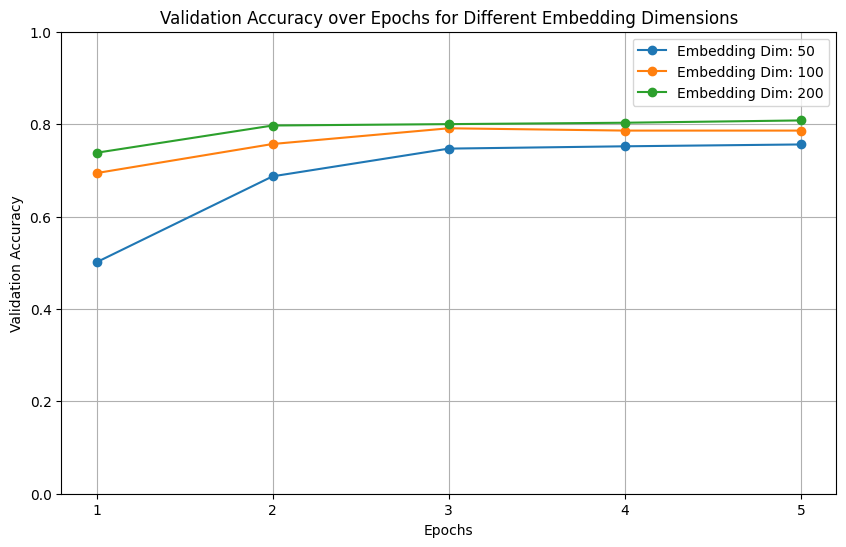

In [447]:
# Results from the training
embedding_dims = [50, 100, 200]  
epoch_accuracy = {
    200: [0.7380, 0.7970, 0.8000, 0.8030, 0.8080],
    100: [0.6940, 0.7570, 0.7910, 0.7860, 0.7860],
    50: [0.5010, 0.6870, 0.7470, 0.7520, 0.7560]
}

plot_accuracy_embed(embedding_dims, epoch_accuracy)


In [448]:
def plot_accuracy_context_size(context_sizes, epoch_accuracy_scores_dict):
    plt.figure(figsize=(10, 6))

    for context_size in context_sizes:
        epoch_accuracy_scores = epoch_accuracy_scores_dict[context_size]
        epochs = list(
            range(1, len(epoch_accuracy_scores) + 1)
        )  # Generate epoch numbers

        plt.plot(
            epochs,
            epoch_accuracy_scores,
            marker="o",
            linestyle="-",
            label=f"Context Size: {context_size}",
        )

    # Adding titles and labels
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.ylim(0, 1)
    plt.xticks(
        list(range(1, max(len(v) for v in epoch_accuracy_scores_dict.values()) + 1))
    )  # Set x-ticks to be the epoch numbers
    plt.grid(True)
    plt.legend()
    plt.show()

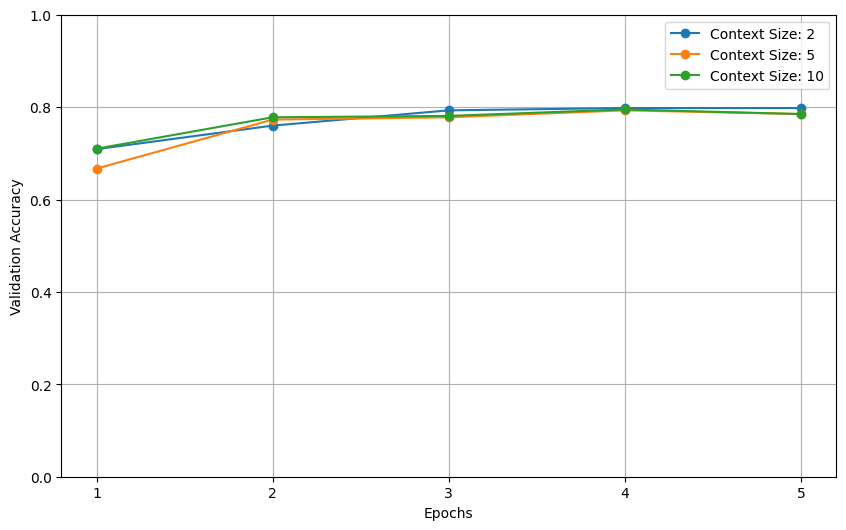

In [449]:
# Results from the training
context_sizes = [2, 5, 10]
epoch_accuracy = {
    2: [0.7090, 0.7600, 0.7930, 0.7980, 0.7980],
    5: [0.6670, 0.7730, 0.7780, 0.7930, 0.7850],
    10: [0.7100, 0.7780, 0.7810, 0.7950, 0.7850]
}

plot_accuracy_context_size(context_sizes, epoch_accuracy)